### JPEG Image Compression and Decompression
#### Divide an image file into blocks of 8x8 pixels
#### For every block, the compression part performs
1. dct (Discrete Cosine Transform)
2. quantization
3. zigzag scan
4. run-length coding (for AC components)
5. huffman coding (for AC components)
#### The decompression part performs
1. huffman decoding
2. run-length decoding
3. inverse zigzag scan
4. inverse quantization
5. inverse dct
#### DC components of all quantized coefficient matrices are treated separately
1. differential coding
2. huffman coding
3, huffman decoding
4. differential decoding

In [38]:
# This cell defines all coding tools for JPEG compression and decompression

%matplotlib inline
import numpy as np
import math
import matplotlib.pyplot as plt

def dct(image_mat):
    N = 8
    coeff_mat = np.zeros((N, N), dtype=int)
    C = [1.0/math.sqrt(2.0)] + [1.0] * (N-1)
    for row in range(N):
        for col in range(N):
            coeff_mat[row][col] = int(1/4  * C[row] * C[col] *
                                   sum([image_mat[x][y] *
                                        math.cos(math.pi*(2*x+1)*row/16) *
                                        math.cos(math.pi*(2*y+1)*col/16)
                                        for x in range(N) for y in range(N)]) )
    return coeff_mat

def idct(coeff_mat):
    N = 8
    image_mat = np.zeros((N, N), dtype=int)
    C = [1.0/math.sqrt(2.0)] + [1.0] * (N-1)
    for x in range(N):
        for y in range(N):
            image_mat[x][y] = int (1/4 *
                                   sum([C[row] * C[col] *
                                        coeff_mat[row][col] *
                                        math.cos(math.pi*(2*x+1)*row/16) *
                                        math.cos(math.pi*(2*y+1)*col/16) 
                                        for row in range(N) for col in range(N)]))
    return image_mat

def q(coeff_mat, q_mat):
    N = 8
    q_coeff_mat = np.zeros((N, N), dtype=coeff_mat.dtype)
    for i in range(N):
        for j in range(N):
            q_coeff_mat[i, j] = int(round(coeff_mat[i, j] / q_mat[i, j]))
    return q_coeff_mat

def iq(q_coeff_mat, q_mat):
    return (q_coeff_mat * q_mat)

def zigzag(coeff_mat):
    N = 8
    coeff_list = []
    for i in range(N):
        if i%2 == 0:
            x, y = i, 0
            for k in range(i+1):
                coeff_list.append(coeff_mat[x,y])
                x, y = x-1, y+1
        else:
            x, y = 0, i
            for k in range(i+1):
                coeff_list.append(coeff_mat[x,y])
                x, y = x+1, y-1
    for j in range(1, N):
        if j%2 != 0:
            x, y = N-1, j
            for k in range(N-j):
                coeff_list.append(coeff_mat[x,y])
                x, y = x-1, y+1
        else:
            x, y = j, N-1
            for k in range(N-j):
                coeff_list.append(coeff_mat[x,y])
                x, y = x+1, y-1
    return coeff_list

def izigzag(input_coeff_list):
    N = 8
    coeff_list = input_coeff_list[:]
    coeff_mat = np.zeros((N, N), coeff_list[0].dtype)
    for i in range(N):
        if i%2 == 0:
            x, y = i, 0
            for k in range(i+1):
                coeff_mat[x,y] = coeff_list.pop(0)
                x, y = x-1, y+1
        else:
            x, y = 0, i
            for k in range(i+1):
                coeff_mat[x,y] = coeff_list.pop(0)
                x, y = x+1, y-1
    for j in range(1, N):
        if j%2 != 0:
            x, y = N-1, j
            for k in range(N-j):
                coeff_mat[x,y] = coeff_list.pop(0)
                x, y = x-1, y+1
        else:
            x, y = j, N-1
            for k in range(N-j):
                coeff_mat[x,y] = coeff_list.pop(0)
                x, y = x+1, y-1
    return coeff_mat

def rl_enc(coeff_list):
    rl_list = []
    i = 0
    zero_count = 0
    while i < len(coeff_list):
        if coeff_list[i] != 0:
            rl_list.append((zero_count, coeff_list[i]))
            i += 1
            zero_count = 0
        else:
            i += 1
            zero_count += 1
    rl_list.append((0, 0))  
    return rl_list

def rl_dec(rl_list):
    coeff_list = []
    for t in rl_list[:-1]:
        for i in range(t[0]):
            coeff_list.append(0)
        coeff_list.append(t[1])        
    coeff_list = coeff_list + [0]*(8*8-1 - len(coeff_list))
    return coeff_list


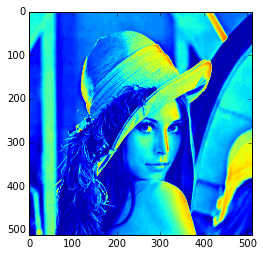

In [39]:
from scipy import misc
import matplotlib.pyplot as plt
import huffman as hf


# A quantization matrix
q_mat = np.array([[16, 11, 10, 16, 24, 40, 51, 61],
                  [12, 12, 14, 19, 26, 58, 60, 55],
                  [14, 13, 16, 24, 40, 57, 69, 56],
                  [14, 17, 22, 29, 51, 87, 80, 62],
                  [18, 22, 37, 56, 68, 109, 103, 77],
                  [24, 35, 55, 64, 81, 104, 113, 92],
                  [49, 64, 78, 87, 103, 121, 120, 101],
                  [72, 92, 95, 98, 112, 100, 103, 99]])


image_src = misc.imread('lenna_grey.png')
H, W = image_src.shape
N = 8

run_pair_list = []  # To collect all run-length pairs of AC components
dc_list = []        # To collect all DC components
decode_dict= {}     # To store all intermediate results

# Encoding Phase
for r in range(0, H//N):
    for c in range(0, W//N):
        image_mat = image_src[r*N:(r+1)*N, c*N:(c+1)*N]
        coeff_mat = dct(image_mat)
        q_coeff_mat = q(coeff_mat, q_mat)
        zz = zigzag(q_coeff_mat)
        dc_list.append(zz[0])
        ac_run = rl_enc(zz[1:])
        decode_dict[(r, c)] = {'imag':image_mat,
                               'coeff_mat':coeff_mat,
                               'q_coeff_mat':q_coeff_mat,
                               'zz':zz,
                               'ac_run':ac_run}
        run_pair_list += ac_run    # Dump all ACs for tree Huffman Tree construction

# Building tree and dictionary for huffman encoding/decoding of DCs
dc_diff_list = dc_list[:]   # Make a deep copy
for i in range(1, len(dc_diff_list)):
    dc_diff_list[i] = dc_list[i-1] - dc_list[i]

dc_tree = hf.gen_huffman_tree(dc_diff_list)
dc_dict = {}
hf.gen_huffman_dict(dc_tree[0], '', dc_dict)
dc_bits = hf.huffman_enc(dc_dict, dc_diff_list)

dc_diff_list_dec = hf.huffman_dec_list(dc_tree, dc_bits)

dc_list_dec = dc_diff_list_dec[:]   # Make a deep copy
for i in range(1, len(dc_list_dec)):
    dc_list_dec[i] = dc_list_dec[i-1] - dc_diff_list_dec[i]

# Building tree and dictionary for huffman encoding/decoding of AC runs
rl_tree = hf.gen_huffman_tree(run_pair_list)
rl_dict = {}
hf.gen_huffman_dict(rl_tree[0], '', rl_dict)    


# Decoding Phase
for r in range(0, H//N):
    for c in range(0, W//N):
        ac_run = decode_dict[(r, c)]['ac_run']       # This is part of encoding
        run_bits = hf.huffman_enc(rl_dict, ac_run)   # Put here b/c we don't have huffman dict
                                                     # yet in the encoding phase
        
        ac_run_dec = hf.huffman_dec_list(rl_tree, run_bits)
        izz = [dc_list_dec[r*(W//N) + c]] +  rl_dec(ac_run_dec)
        iq_coeff_mat= izigzag(izz)
        icoeff_mat = iq(iq_coeff_mat, q_mat)
        image_dec = idct(icoeff_mat)
        
        decode_dict[(r, c)]['run_bits'] = run_bits
        decode_dict[(r, c)]['ac_run_dec'] = ac_run_dec
        decode_dict[(r, c)]['izz'] = izz
        decode_dict[(r, c)]['iq_coeff_mat'] = iq_coeff_mat
        decode_dict[(r, c)]['icoeff_mat'] = icoeff_mat
        decode_dict[(r, c)]['image_dec'] = image_dec
        
# Output decoded image
reconstructed = np.zeros((H, W), dtype=image_src.dtype)
for r in range(0, H//N):
    for c in range(0, W//N):
        reconstructed[r*N:(r+1)*N, c*N:(c+1)*N] = decode_dict[(r, c)]['image_dec']

misc.imsave('lenna_grey_reconstructed.png', reconstructed)
plt.imshow(reconstructed)

In [40]:
# Print out all intermediate results of a block
for k in ['imag', 'coeff_mat', 'q_coeff_mat',  'zz', 'ac_run', 'run_bits',
          'ac_run_dec',  'izz', 'iq_coeff_mat', 'icoeff_mat', 'image_dec']:
    print (k, ":")
    print (decode_dict[(10, 8)][k])
print ("Residual:")
print (decode_dict[(10,8)]['imag'] - decode_dict[(10, 8)]['image_dec'])


imag :
[[34 32 26 26 22 26 27 31]
 [33 29 27 27 23 26 29 31]
 [34 30 28 26 26 28 30 32]
 [32 30 25 26 27 25 30 32]
 [33 31 26 25 26 26 28 32]
 [36 33 30 26 27 29 30 33]
 [36 33 28 26 29 26 30 33]
 [36 31 27 27 29 28 30 30]]
coeff_mat :
[[232   5  21   1   4   0  -1   0]
 [ -5   0   1  -2  -1   2   0  -3]
 [  0   2   0   0   0   1   0  -1]
 [  0   1   2  -1   0  -1   0  -1]
 [ -3   0   0   0   1   0  -1  -1]
 [  1   0   0   0   0  -1  -1   0]
 [  2   0   0   1  -1   0   1   0]
 [  0   0   0   0   0  -1   0   0]]
q_coeff_mat :
[[14  0  2  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0]]
zz :
[14, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
ac_run :
[(4, 2), (0, 0)]
run_bits :
0101011011111
ac

In [ ]:
# This part show Basis pattern for DCT TRansform
def basis(x, y):
    N = 8
    pat_mat = np.zeros((N, N), dtype=float)
    for row in range(N):
        for col in range(N):
            pat_mat[row][col] = math.cos(math.pi*(2*x)*row/16) * math.cos(math.pi*(2*y)*col/16)
    return pat_mat

pat = basis(0, 3)

plt.imshow(pat, cmap='Greys_r')
plt.colorbar()